## 1. Import thư viện và tải dữ liệu

In [ ]:
import sys
import os
import numpy as np

# Thêm thư mục nguồn vào sys.path để import các module tự định nghĩa
sys.path.append(os.path.abspath(os.path.join('..')))

# Import model RandomForest và các hàm xử lý dữ liệu
from src.models import RandomForest
from src import models as md
from src import visualization as viz
from src import data_processing as dp

In [2]:
def load_processed_data(filename):
    """Tải dữ liệu đã được xử lý từ tệp CSV."""
    filepath = f'../data/processed/{filename}'
    try:
        data = np.genfromtxt(filepath, delimiter=',', names=True, dtype=None, encoding='utf-8')
        print(f"Tải {filename} thành công với shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Lỗi khi tải {filename}: {e}")
        return None

train_data = load_processed_data('aug_train_processed.csv')
test_data = load_processed_data('aug_test_processed.csv')

Tải aug_train_processed.csv thành công với shape: (19109,)
Tải aug_test_processed.csv thành công với shape: (2129,)


## 2. Chuẩn bị dữ liệu

Trước khi đưa vào mô hình, dữ liệu cần được chuẩn bị kỹ lưỡng để đảm bảo tính khách quan và hiệu quả huấn luyện:
1.  **Tách dữ liệu (Train/Validation Split):** Chia tập dữ liệu huấn luyện gốc (`train_data`) thành hai phần: tập huấn luyện (`train`) để dạy mô hình và tập xác thực (`validation`) để đánh giá hiệu suất trong quá trình phát triển.
2.  **Xử lý mất cân bằng:** Sử dụng kỹ thuật **Random Oversampling** để sinh thêm các mẫu dữ liệu cho lớp thiểu số trong tập huấn luyện. Lưu ý quan trọng là kỹ thuật này chỉ được áp dụng trên tập `train`, không áp dụng trên tập `validation` hay `test` để tránh rò rỉ dữ liệu (data leakage).
3.  **Chuẩn bị tập Test:** Định dạng dữ liệu tập kiểm tra (`test_data`) để sẵn sàng cho việc dự đoán cuối cùng.

In [3]:
# Tách X và y từ tập train_data_full
X_full, y_full = md.get_features_and_target(train_data)

# Chia thành tập train và validation
if X_full is not None:
    X_train, X_val, y_train, y_val = md.train_val_split(X_full, y_full, val_size=0.2)
    print(f"Kích thước trước khi Oversampling: X_train shape={X_train.shape}, y_train shape={y_train.shape}")
    print(f"Tỷ lệ lớp 1 ban đầu: {np.mean(y_train):.2f}")
    
    # Áp dụng oversampling chỉ trên tập train
    X_train, y_train = md.random_oversample(X_train, y_train)
    print(f"Kích thước sau khi Oversampling: X_train shape={X_train.shape}, y_train shape={y_train.shape}")
    print(f"Tỷ lệ lớp 1 sau đó: {np.mean(y_train):.2f}")

    print(f"Validation set: X_val shape={X_val.shape}, y_val shape={y_val.shape}")

# Chuẩn bị tập test cuối cùng
X_test, _ = md.get_features_and_target(test_data)
if X_test is not None:
    print(f"Test set: X_test shape={X_test.shape}")

Kích thước trước khi Oversampling: X_train shape=(15288, 20), y_train shape=(15288,)
Tỷ lệ lớp 1 ban đầu: 0.25
Kích thước sau khi Oversampling: X_train shape=(22906, 20), y_train shape=(22906,)
Tỷ lệ lớp 1 sau đó: 0.50
Validation set: X_val shape=(3821, 20), y_val shape=(3821,)
Test set: X_test shape=(2129, 20)


## 3. Huấn luyện Model

### 3.1. Huấn luyện mô hình Random Forest trên tập dữ liệu đã được xử lý

In [4]:
# Khởi tạo classifier
seed = 13
clf = RandomForest(n_trees=100, 
                   max_depth=20, 
                   min_samples_split=30, 
                   min_info_gain=1e-4,
                   random_state=seed)

# Huấn luyện model
print("Đang huấn luyện model Random Forest...")
if 'X_train' in locals():
    clf.fit(X_train, y_train)
    print("Huấn luyện hoàn tất.")
else:
    print("Không thể huấn luyện do lỗi tải dữ liệu.")

Đang huấn luyện model Random Forest...


Training Forest: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]

Huấn luyện hoàn tất.


### 3.2. Feature Importance

Sau khi quá trình huấn luyện hoàn tất, mô hình đã xác định được mức độ ảnh hưởng của từng đặc trưng. Ta trực quan hóa kết quả này để làm rõ tầm quan trọng của từng cột dữ liệu.

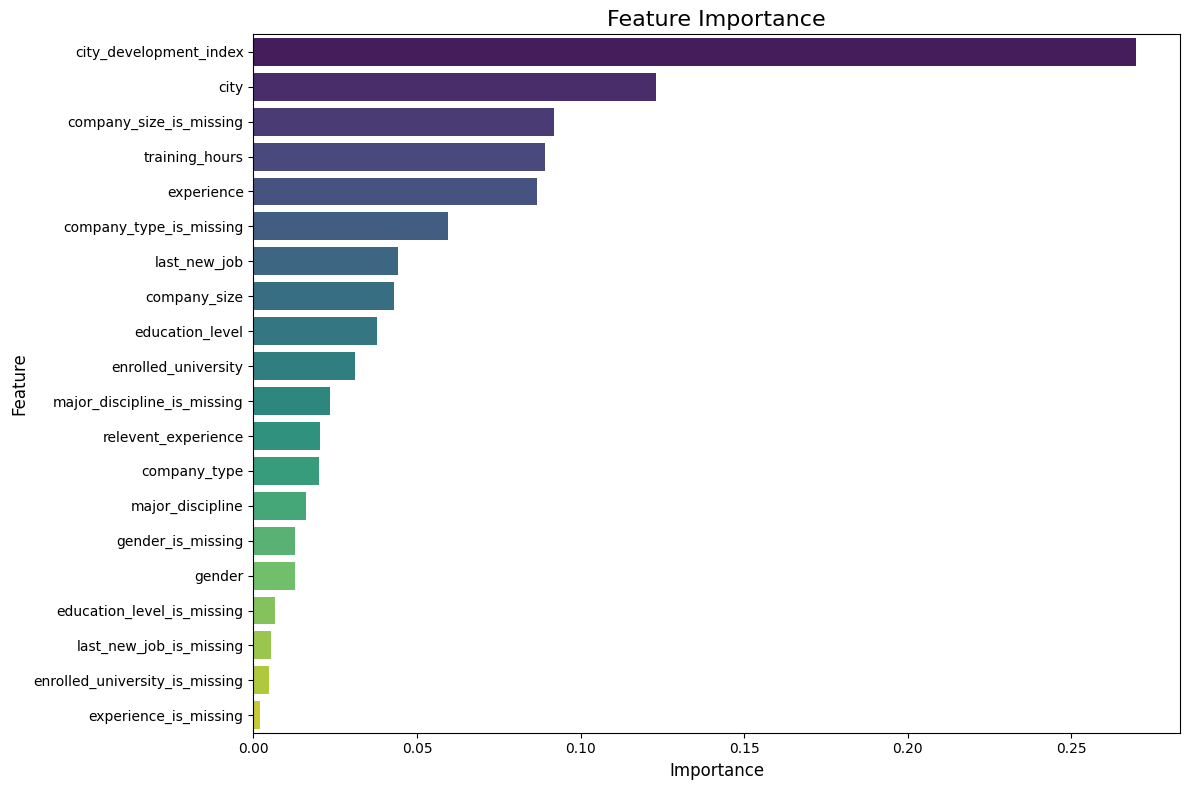

In [5]:
feature_names = [n for n in train_data.dtype.names if n != 'target']
viz.plot_feature_importance(clf.feature_importances_, feature_names)

Biểu đồ cho thấy mức độ đóng góp của từng biến đầu vào đến khả năng dự đoán của mô hình. Một số nhận xét chính:

**1. city_development_index là yếu tố quan trọng nhất**

Biến *city_development_index* chiếm tỷ trọng importance cao nhất (gần 0.25), cao vượt trội so với tất cả các biến khác.
Điều này cho thấy **mức độ phát triển của thành phố** nơi ứng viên sinh sống có ảnh hưởng rất mạnh đến khả năng họ tìm được công việc mới.

**2. Các biến chỉ báo giá trị thiếu của công ty cũng mang tính quyết định**

Hai biến:
* *company_size_is_missing*
* *company_type_is_missing*

nằm trong nhóm quan trọng nhất.
Điều này cho thấy việc thiếu thông tin về công ty hiện tại của ứng viên **chứa một tín hiệu rõ ràng**, trùng khớp với dự đoán trong `01_data_exploration.ipynb` về pattern thiếu dữ liệu của 2 cột **company_size** và **company_type**

**3. Một số biến *is_missing* có importance thấp**

Các biến:
* *major_discipline_is_missing*
* *gender*
* *last_new_job_is_missing*
* *education_level_is_missing*
* *enrolled_university_is_missing*
* *experience_is_missing*

đều có importance rất thấp gần bằng 0.
Điều này cho thấy dữ liệu thiếu ở các cột này **không mang thêm thông tin đáng kể** và mô hình hầu như không sử dụng chúng để phân chia.

## 4. Đánh giá mô hình

Tiếp theo, ta sẽ tiến hành **đánh giá hiệu năng mô hình** thông qua các chỉ số  như **Precision**, **Recall** và **F1-Score**, đồng thời trực quan hóa chất lượng phân loại bằng **đường cong ROC** và **giá trị AUC** cho từng lớp. Các phép đánh giá sẽ được thực hiện trên cả **train** và **validation** nhằm quan sát sự khác biệt giữa hai tập, từ đó phát hiện sớm các dấu hiệu **overfitting** hoặc **underfitting** của mô hình.

-- Đánh giá trên tập Train --
Overall accuracy: 0.8489
Chỉ số theo từng lớp:
  Class 0: Precision=0.8625, Recall=0.8301, F1-Score=0.8460
  Class 1: Precision=0.8362, Recall=0.8676, F1-Score=0.8516
------------------------------------
AUC Score: 0.9350


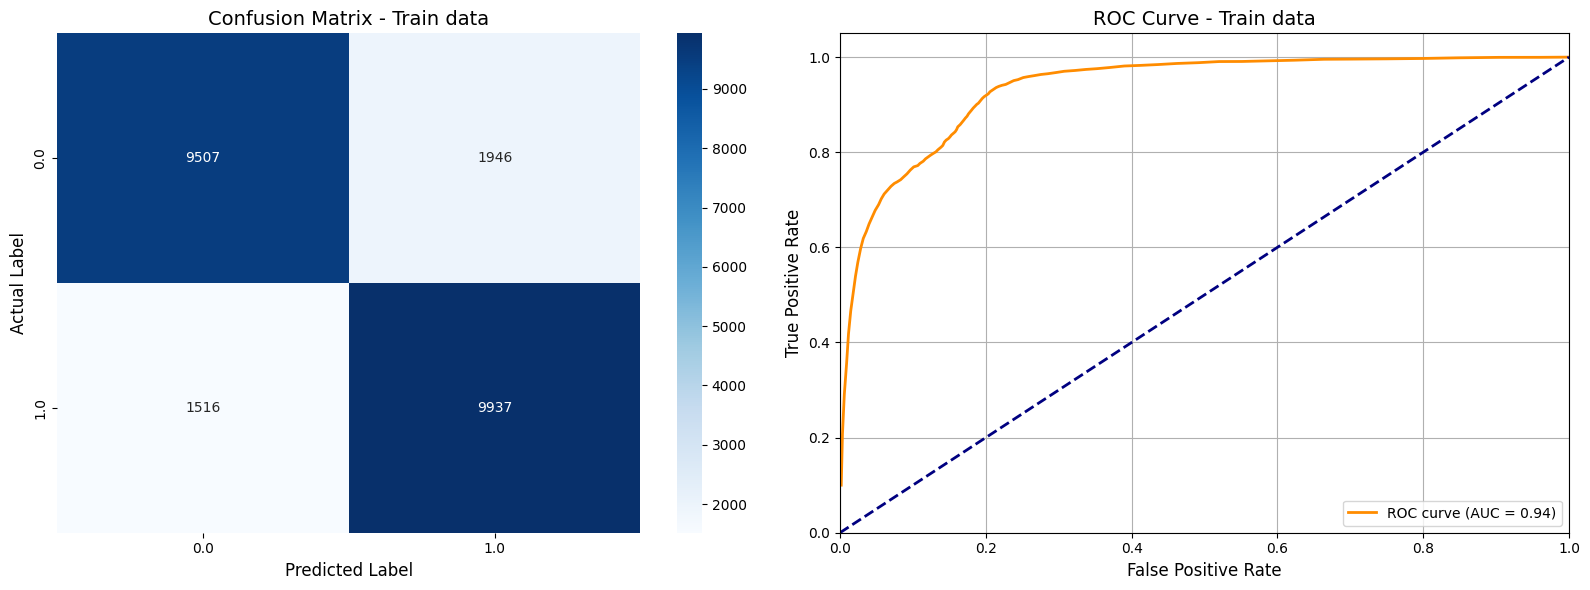

-- Đánh giá trên tập Validation --
Overall accuracy: 0.7893
Chỉ số theo từng lớp:
  Class 0: Precision=0.8984, Recall=0.8136, F1-Score=0.8539
  Class 1: Precision=0.5520, Recall=0.7140, F1-Score=0.6226
------------------------------------
AUC Score: 0.7998


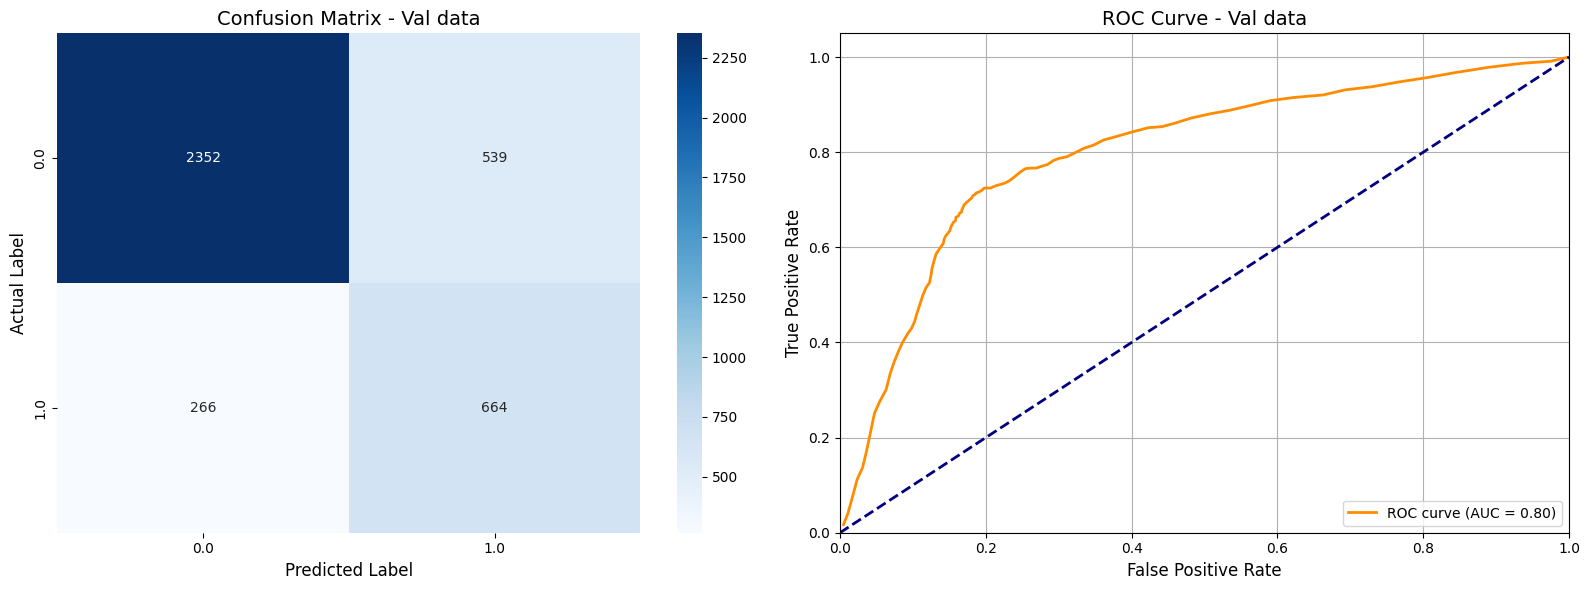

In [6]:
if 'X_train' in locals():
    # --- Đánh giá trên tập huấn luyện ---

    # Lấy các chỉ số cơ bản
    md.evaluate_model_detailed(clf, X_train, y_train, "Train")
    
    # Lấy dự đoán và xác suất để vẽ biểu đồ
    y_train_pred = clf.predict(X_train)
    y_train_pred_proba = clf.predict_proba(X_train)
    
    # Vẽ biểu đồ
    viz.plot_evaluation_visuals(y_train, y_train_pred, y_train_pred_proba, 
                                dataset_name="Train data")

    # --- Đánh giá trên tập xác thực ---
    
    # Lấy các chỉ số cơ bản
    md.evaluate_model_detailed(clf, X_val, y_val, "Validation")
    
    # Lấy dự đoán và xác suất để vẽ biểu đồ
    y_val_pred = clf.predict(X_val)
    y_val_pred_proba = clf.predict_proba(X_val)
    
    # Vẽ biểu đồ
    viz.plot_evaluation_visuals(y_val, y_val_pred, y_val_pred_proba,
                                dataset_name="Val data")

1.  **Dấu hiệu Overfitting:** Có sự chênh lệch rõ rệt giữa tập Train (AUC **0.94**, F1 Class 1 **0.85**) và tập Validation (AUC **0.80**, F1 Class 1 **0.62**). Điều này là bình thường khi sử dụng kỹ thuật Oversampling trên tập Train, khiến mô hình học quá kỹ các mẫu lặp lại, trong khi tập Validation giữ nguyên phân phối thực tế khắt khe hơn.

2.  **Hiệu quả bắt đúng nhóm nghỉ việc (Class 1):**
    *   Trên tập Validation thực tế (mất cân bằng), chỉ số **Recall của Class 1 đạt 0.71**. Đây là một kết quả tốt cho bài toán HR. Nghĩa là mô hình nhận diện thành công **71%** số nhân viên thực sự có ý định nghỉ việc, giúp công ty không bỏ sót các trường hợp rủi ro.

3.  **Trade-off:**
    *   Để đạt được Recall cao, mô hình đã hy sinh **Precision (chỉ đạt 0.55)**. Nhìn vào Confusion Matrix (Validation), số lượng **False Positive là 539** (dự báo nghỉ nhưng thực tế ở lại) khá cao so với True Positive (664).
    *   Điều này đồng nghĩa: Cứ 2 người mô hình cảnh báo "sắp nghỉ", thì chỉ có khoảng 1 người nghỉ thật.

**Kết luận:** Mô hình chấp nhận được với bài toán này theo tiêu chí **"thà báo nhầm còn hơn bỏ sót"**. Việc phát hiện được 71% ứng viên tiềm năng muốn đổi việc quan trọng hơn sự chính xác tuyệt đối.

## 5. Đánh giá bằng Cross-Validation

Để có một ước tính hiệu năng đáng tin cậy hơn, ta thực hiện k-fold cross-validation trên toàn bộ tập dữ liệu huấn luyện (`X_full`, `y_full`). Thao tác này giúp đảm bảo rằng kết quả không bị phụ thuộc vào một cách chia train-validation cụ thể.

In [7]:
if 'X_full' in locals():
    # Định nghĩa các tham số cho mô hình
    clf_params = {
        'n_trees': 100, 
        'max_depth': 20,
        'min_samples_split': 30,  
        'min_info_gain': 1e-4,
        'random_state': seed
    }
    
    # Chạy cross-validation
    md.cross_validation(md.RandomForest, clf_params, X_full, y_full, k=5)

--- Bắt đầu 5-Fold Cross-Validation ---
  Fold 1/5...


Training Forest: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


  Fold 2/5...


Training Forest: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


  Fold 3/5...


Training Forest: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


  Fold 4/5...


Training Forest: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


  Fold 5/5...


Training Forest: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]



--- Kết quả Cross-Validation (Trung bình) ---
  Average Accuracy: 0.7927 (std: 0.0081)
  Average AUC:      0.7982 (std: 0.0073)
  Class 0:
    - Precision: 0.8537 (std: 0.0019)
    - Recall:    0.8736 (std: 0.0114)
    - F1-Score:  0.8635 (std: 0.0061)
  Class 1:
    - Precision: 0.5916 (std: 0.0209)
    - Recall:    0.5492 (std: 0.0065)
    - F1-Score:  0.5694 (std: 0.0094)
------------------------------------------


1.  **Độ ổn định cao:** Điểm sáng lớn nhất là độ lệch chuẩn cực thấp ở mọi chỉ số (đều < 1%). Điều này khẳng định thuật toán Random Forest tự cài đặt hoạt động rất ổn định, kết quả không bị may rủi do cách chia dữ liệu.

2.  **Khả năng phân loại tốt:** Chỉ số **AUC đạt ~0.80** là một kết quả khả quan. Nó cho thấy mô hình có khả năng xếp hạng xác suất ứng viên muốn nghỉ việc tốt hơn nhiều so với Accuracy thuần túy.

3.  **Vẫn chịu ảnh hưởng của mất cân bằng:** Mặc dù tổng thể tốt, hiệu năng trên nhóm thiểu số (Class 1) vẫn còn khiêm tốn (F1 ~0.57). Với Recall ~55%, mô hình hiện tại thiên về hướng "an toàn" – độ chính xác (Precision) nhỉnh hơn một chút so với độ bao phủ (Recall), tức là "đã báo là đúng, nhưng còn bỏ sót khá nhiều". 

## 6. Huấn luyện lại trên toàn bộ tập dữ liệu

Sau khi đã đánh giá mô hình thông qua tập Validation và Cross-Validation, ta đã xác định được bộ tham số tối ưu và hiệu suất kỳ vọng. Để đạt được kết quả tốt nhất trên tập test, ta nên tận dụng **toàn bộ dữ liệu huấn luyện** (`X_full`, `y_full`) để dạy mô hình.

Quy trình thực hiện:
1.  **Oversampling toàn bộ tập train:** Áp dụng kỹ thuật Random Oversampling lên toàn bộ dữ liệu gốc để xử lý mất cân bằng.
2.  **Huấn luyện lại:** Khởi tạo một mô hình mới với các tham số đã chọn và huấn luyện trên tập dữ liệu đầy đủ đã được cân bằng.

In [ ]:
print("--- Bắt đầu quy trình huấn luyện lại lần cuối ---")

if 'X_full' in locals() and 'y_full' in locals():
    # 1. Áp dụng Random Oversampling trên toàn bộ tập dữ liệu
    print(f"Kích thước ban đầu: {X_full.shape}, Tỷ lệ lớp 1: {np.mean(y_full):.2f}")
    X_full_resampled, y_full_resampled = md.random_oversample(X_full, y_full)
    print(f"Kích thước sau khi Oversampling: {X_full_resampled.shape}, Tỷ lệ lớp 1: {np.mean(y_full_resampled):.2f}")

    # 2. Khởi tạo mô hình cuối cùng với các tham số đã tinh chỉnh
    clf_final = RandomForest(n_trees=100, 
                             max_depth=20, 
                             min_samples_split=30, 
                             min_info_gain=1e-4,
                             random_state=seed)

    # 3. Huấn luyện
    print("Đang huấn luyện mô hình trên toàn bộ dữ liệu...")
    clf_final.fit(X_full_resampled, y_full_resampled)
    print("Huấn luyện model cuối cùng hoàn tất.")
else:
    print("Không tìm thấy dữ liệu gốc (X_full, y_full).")

--- Bắt đầu quy trình huấn luyện lại lần cuối ---
Kích thước ban đầu: (19109, 20), Tỷ lệ lớp 1: 0.25
Kích thước sau khi Oversampling: (28688, 20), Tỷ lệ lớp 1: 0.50
Đang huấn luyện mô hình trên toàn bộ dữ liệu...


Training Forest: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]

Huấn luyện model cuối cùng hoàn tất.


## 7. Dự đoán trên tập Test

Bước cuối cùng là sử dụng mô hình đã được huấn luyện để tạo ra dự đoán cho tập test cuối cùng.

In [ ]:
# Thực hiện dự đoán trên tập test
if 'X_test' in locals() and X_test is not None:
    print("Thực hiện dự đoán trên tập test cuối cùng...")
    test_predictions = clf_final.predict(X_test)
    print("Dự đoán hoàn tất.")
    
    # # Lưu kết quả dự đoán
    raw_test_data = dp.load_data('../data/raw/aug_test.csv')
    if raw_test_data is not None:
        test_enrollee_ids = raw_test_data['enrollee_id']
        submission_data = np.array(list(zip(test_enrollee_ids, test_predictions)), dtype=[('enrollee_id', 'i4'), ('target', 'i2')])
        np.savetxt('../submission.csv', submission_data, delimiter=',', fmt='%d', header='enrollee_id,target', comments='')
        print("Đã lưu file submission.csv thành công.")

Thực hiện dự đoán trên tập test cuối cùng...
Dự đoán hoàn tất.
Đã lưu file submission.csv thành công.
